In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from notears import NOTEARS
from notears.data import generate_continuous_dag, generate_random_data
from notears.loss import LinearSEMLoss

from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Set seed for reproducability
np.random.seed(122)
# Update parameters for plots
plt.rcParams.update({
    'axes.titlesize': 10,  # Title font size
    'axes.labelsize': 9,  # Axis label font size
    'figure.titlesize':10,
    'xtick.labelsize': 8,  # X-axis tick label font size
    'ytick.labelsize': 8,  # Y-axis tick label font size
    'legend.fontsize': 9,  # Legend font size
    'font.family':'sans-serif',
    'axes.grid': True,  # Enable the grid
    'grid.linestyle': '-',  # Set grid line style
    'grid.linewidth': 0.5,  # Set grid line width
    'grid.color': 'gray',  # Set grid line color
    'grid.alpha': 0.2,  # Set grid line transparency
    'figure.figsize' : (5.949910059499101, 3.677246646775354)
})

# Primary Demonstration
As a first step we simply create a small graph and apply NOTEARS on it.

In [2]:
from joblib import Parallel, delayed
from typing import Any
from notears.metrics import (
    calculate_fdr, calculate_shd, 
    calculate_tpr, calculate_fpr
)

def run(data:np.ndarray, nt:NOTEARS):
    result = nt.fit(data).get_discovered_graph()
    return result

def run_and_score(data:np.ndarray, dag:np.ndarray, nt:NOTEARS, omega:float, **kwargs):
    # Run NOTEARS
    dag_found = nt.fit(data).get_discovered_graph(omega)
    # Get all metrics
    return dict(
        fdr=calculate_fdr(dag, dag_found), 
        shd=calculate_shd(dag, dag_found), 
        tpr=calculate_tpr(dag, dag_found), 
        fpr=calculate_fpr(dag, dag_found),
        **kwargs
    )

def repeated_run(nt:NOTEARS, data:np.ndarray, n_runs=1, params:list[dict[str, Any]]=None) -> np.ndarray:
    if params == None:
        results = Parallel(n_jobs=-1)(
            delayed(run)(data, nt) for _ in tqdm(range(n_runs), desc='Running Test', leave=False)
        )
    else:
        results = Parallel(n_jobs=-1)(
            delayed(run)(data, nt.set_params(**param)) for param in tqdm(params*n_runs, desc='Running Test', leave=False)
        )
    c = n_runs if not params else n_runs*len(params)
    return np.sum(results, axis=0) / c

def param_test(
        nt:NOTEARS, data:np.ndarray, dag:np.ndarray, omega:float, n_runs:int,
        params_grid:list[dict[str, Any]]
    ) -> list[dict[str, Any]]:
    all_test_param = (param for _ in range(n_runs) for param in params_grid)
    results = Parallel(n_jobs=-1)(
        delayed(run_and_score)(data, dag, nt.set_params(**param), omega, **param) 
        for param in tqdm(all_test_param, desc='Running Test', total=n_runs*len(params_grid))
    )
    return results

In [3]:
from itertools import product

def highlight_cell(x:int, y:int, ax:Axes, **kwargs):
    rect = plt.Rectangle((y, x), 1, 1, fill=False, **kwargs)
    ax.add_patch(rect)
    return rect

def show_graphs(dag:np.ndarray, dag_found:np.ndarray, ax:Axes):
    d, _ = dag.shape
    # Plot the found graph
    df_found = pd.DataFrame(dag_found)
    sns.heatmap(df_found, cmap='Reds', ax=ax, cbar=False)
    # Plot the true graph
    for i, j in product(range(d), range(d)):
        if dag[i, j] != 0:
            highlight_cell(i, j, ax, color="limegreen", linewidth=2.5)

Random Experiment:   0%|          | 0/4 [00:00<?, ?it/s]

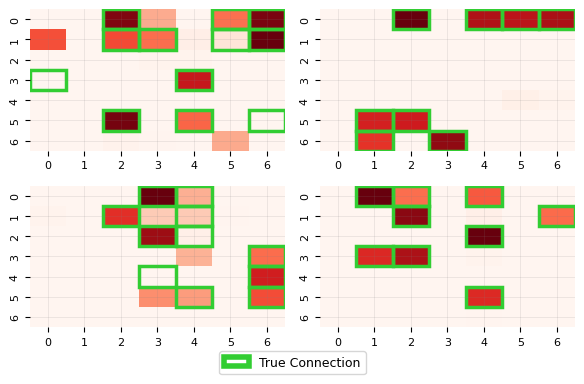

In [4]:
# Plot results
fig, axs = plt.subplots(2, 2)

# Run 2 tests
for test in tqdm(range(4), desc='Random Experiment'):
    dag = generate_continuous_dag(7, 0.5)
    data = generate_random_data(dag, 2000)
    # Fit notears and get results
    nt = NOTEARS(l1=0.01, eps=1e-8, c=0.25, objective=LinearSEMLoss()).fit(data)
    dag_found = nt.get_discovered_graph()
    show_graphs(dag, dag_found, axs[test%2, test//2])

# Show results
fig.subplots_adjust(bottom=0.2)
green_patch = patches.Patch(edgecolor='limegreen', facecolor='none', label='True Connection', linewidth=4)
fig.legend(handles=[green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.05))
fig.tight_layout()
fig.savefig('./result/preliminary.pdf')
plt.show()

# Test 1: Cutoff Omega
This test is to see how sensitive the cutoff value $\omega$ is.

In [5]:
from notears.metrics import find_dag_violation_threshold

def plot_thresholds(W:np.ndarray, ax:Axes) -> Figure:
    W_abs = np.abs(W)
    flat = np.sort(W_abs.flatten())[::-1]
    n_edges = np.arange(len(flat), 0, -1)
    threshold = find_dag_violation_threshold(
        W_abs
    )
    # Plot results
    ax.plot(flat, n_edges)
    ax.set_xscale('log')
    ax.axvline(x=threshold, color='r', linestyle='--', label='Violation Threshold')

  0%|          | 0/4 [00:00<?, ?it/s]

Running Test:   0%|          | 0/10 [00:00<?, ?it/s]

Running Test:   0%|          | 0/10 [00:00<?, ?it/s]

Running Test:   0%|          | 0/10 [00:00<?, ?it/s]

Running Test:   0%|          | 0/10 [00:00<?, ?it/s]

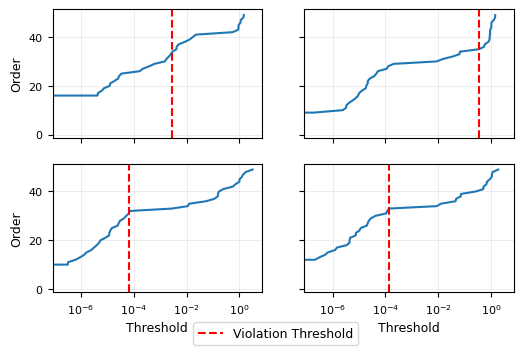

In [6]:
# Plot results
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

# Run 4 tests
nt = NOTEARS(l1=0.01, eps=1e-8, c=0.25, objective=LinearSEMLoss())
for test in tqdm(range(4)):
    dag = generate_continuous_dag(7, 0.5)
    data = generate_random_data(dag, 2000)
    # Fit notears and get results
    dag_found = repeated_run(nt, data, n_runs=10)
    plot_thresholds(dag_found, axs[test%2, test//2])

# Show legend
handles, labels = axs[1,1].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05))
# Show axis names
axs[0,0].set_ylabel('Order')
axs[1,0].set_ylabel('Order')
axs[1,0].set_xlabel('Threshold')
axs[1,1].set_xlabel('Threshold')
fig.savefig('./result/threshold.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

# Test Substructure


  0%|          | 0/3 [00:00<?, ?it/s]

Running Test:   0%|          | 0/40 [00:00<?, ?it/s]

Running Test:   0%|          | 0/40 [00:00<?, ?it/s]

Running Test:   0%|          | 0/40 [00:00<?, ?it/s]

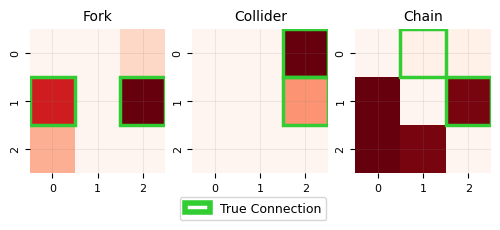

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(5.949910059499101, 5.949910059499101 / 2.8))

for i, structure in tqdm(enumerate(['fork','collider', 'chain']), total=3):
    dag = np.zeros((3, 3))
    l1 = 0
    if structure == 'fork':
        dag[1, [0, 2]] = [2, 2]
        l1 = 0
    elif structure == 'collider':
        dag[[0, 1], 2] = [2, 2]
        l1 = 0.5
    elif structure == 'chain':
        dag[0, 1] = 1
        dag[1, 2] = 1
        l1 = 0.1
    elif structure == 'complex':
        dag[0, [1, 2]] = [2, 2]
        dag[1, 2] = 1
        l1 = 0
    
    data = generate_random_data(dag, 1000, noise_scale=0.0001)
    nt= NOTEARS(l1=l1, eps=1e-8, c=0.9, objective=LinearSEMLoss())
    dag_found = repeated_run(nt, data, n_runs=40)
    axs[i].set_title(structure.capitalize())
    show_graphs(dag, dag_found, axs[i])

fig.subplots_adjust(bottom=0.2)
green_patch = patches.Patch(edgecolor='limegreen', facecolor='none', label='True Connection', linewidth=4)
legend = fig.legend(handles=[green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.05))
fig.savefig('./result/substructure.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

In [8]:
from datetime import datetime

def timit(nt:NOTEARS, d, n, alpha) -> float:
    # Generate random Data
    dag = generate_continuous_dag(d, alpha)
    data = generate_random_data(dag, n)
    # Time the fit function
    start = datetime.now()
    nt.fit(data)
    end = datetime.now()
    # Return time informstion
    return ((end-start).total_seconds(), nt._meta['iterations'])

def test_runtime(nt:NOTEARS, d:int, n:int, alpha:float, nruns:int):
    tasks = (delayed(timit)(nt, d, n, alpha) for _ in range(nruns))
    runtimes = Parallel(n_jobs=-1)(tasks)
    return runtimes

In [9]:
runtimes = []
nt = NOTEARS(l1=0.5, eps=1e-8, c=0.25, objective=LinearSEMLoss())
for size in tqdm(range(4, 13), desc='Testing Runtime'):
    runtimes.extend(map(
        lambda x: {'Graph Size':size, 'Runtime (sec)':x[0], 'Iterations':x[1]},
        test_runtime(nt, size, 500, 0.5, 10)
    ))

Testing Runtime:   0%|          | 0/9 [00:00<?, ?it/s]

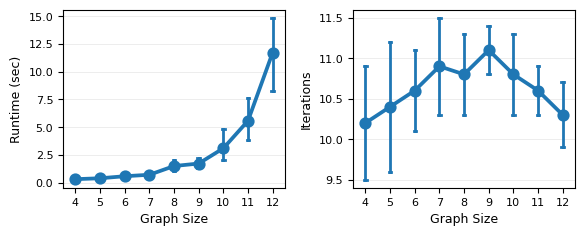

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.949910059499101, 3.677246646775354 * 0.67))

data = pd.DataFrame(runtimes)
sns.pointplot(data, x='Graph Size', y='Runtime (sec)', err_kws={'linewidth': 2}, capsize=0.1, ax=ax1)
sns.pointplot(data, x='Graph Size', y='Iterations', err_kws={'linewidth': 2}, capsize=0.1, ax=ax2)

fig.tight_layout()
fig.savefig('./result/runtime.pdf')
plt.show()

In [11]:
# Generate random data
dag = generate_continuous_dag(7, 0.5)
data = generate_random_data(dag, 400)
dag_binary = (dag != 0).astype(int)

# Define the notears object and the parameter grid
params_grid = [{'c':x} for x in np.arange(0.01, 1, 0.05)]
nt = NOTEARS(l1=0.5, eps=1e-8, c=0.25, objective=LinearSEMLoss())

# Run the tests
results = param_test(
    nt, data, dag_binary, n_runs=5,
    omega=1e-4, # Not optimal to fix this parameter
    params_grid=params_grid
)

Running Test:   0%|          | 0/100 [00:00<?, ?it/s]

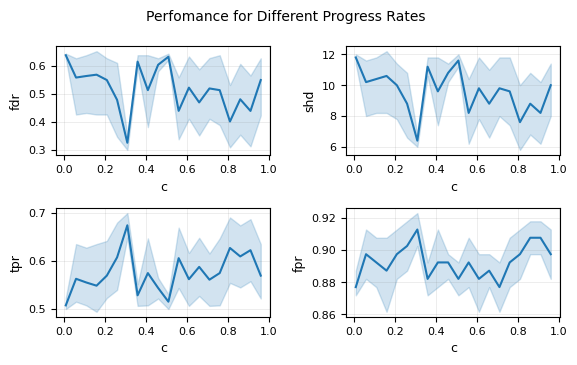

In [12]:
fig, axs = plt.subplots(2, 2)

data = pd.DataFrame(results)
sns.lineplot(data, x='c', y='fdr', ax=axs[0,0])
sns.lineplot(data, x='c', y='shd', ax=axs[0,1])
sns.lineplot(data, x='c', y='tpr', ax=axs[1,0])
sns.lineplot(data, x='c', y='fpr', ax=axs[1,1])
fig.suptitle('Perfomance for Different Progress Rates')
fig.tight_layout()
fig.savefig('./result/progres_rate.pdf')
plt.show()

# Effect repeated runs

Random Experiment:   0%|          | 0/2 [00:00<?, ?it/s]

Running Test:   0%|          | 0/80 [00:00<?, ?it/s]

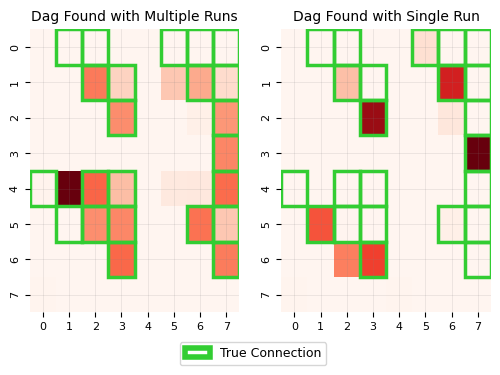

In [13]:
# Plot results
fig, axs = plt.subplots(1, 2)

# Run 2 tests
dag = generate_continuous_dag(8, 0.8)
data = generate_random_data(dag, 100, noise_scale=0.5)

params_grid = [{'l1':l1} for l1 in [0, 0.01, 0.1, 1]]
for i, n_runs in tqdm(enumerate([1, 20]), total=2, desc='Random Experiment'):
    # Fit notears and get results
    nt = NOTEARS(0.00, 1e-8, 0.25, LinearSEMLoss())
    if i == 0:
        dag_found = nt.fit(data).get_discovered_graph()
    else:
        dag_found = repeated_run(nt, data, n_runs=n_runs, params=params_grid)
    show_graphs(dag, dag_found, axs[i])

# Show results
axs[0].set_title('Dag Found with Multiple Runs')
axs[1].set_title('Dag Found with Single Run')

green_patch = patches.Patch(edgecolor='limegreen', facecolor='none', label='True Connection', linewidth=4)
legend = fig.legend(handles=[green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.05))
fig.savefig('./result/multiple_runs.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()